In [62]:
import scipy.io
import torch
import importlib
import matplotlib.pyplot as plt

In [63]:
import src2.HyperParameters as hp 
import src2.data as dt 
import src2.model as Model 
import src2.train as trainer

importlib.reload(hp)
importlib.reload(dt)
importlib.reload(Model)
importlib.reload(trainer)

<module 'src2.train' from '/Users/ramtarun/Desktop/Cambridge/Indirect-Noise-in-Nozzles/src2/train.py'>

In [64]:
data = scipy.io.loadmat('/Users/ramtarun/Desktop/Cambridge/Indirect-Noise-in-Nozzles/Data/Data_PINN_subsonic_geom_linvelsup_f0-0.1.mat')

In [65]:
# inputs, targets, meanflow =  dt.DataPreprocessing(data, ff=0.01)
# train_loader, val_loader = dt.DataTransformer(inputs, targets, meanflow, TrainingSet=True)


In [66]:
PINN_model = Model.PINN()


In [67]:
params = list(PINN_model.parameters())
optimizer = torch.optim.Adam([{'params' : params[1::]},{'params' : params[0], 'lr': hp.ff_learning_rate}], lr = hp.learning_rate, amsgrad = True)   

# optimizer = torch.optim.LBFGS(params, hp.ff_learning_rate, 
#                               max_iter = hp.epochs, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-11, 
#                               tolerance_change = 1e-11, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')


In [68]:
fval = [0.1  , 0.06 , 0.04, 0.01]

for f in fval:
    inputs, targets, meanflow =  dt.DataPreprocessing(data, ff=f)
    train_loader, val_loader = dt.DataTransformer(inputs, targets, meanflow, TrainingSet=True)
    trainer.train(train_loader, val_loader, hp.epochs, optimizer, PINN_model)


Epoch 5000/50000 - Train Loss: 0.000052 Val Loss: 0.004936 f_PINN: 0.1253519058227539
Epoch 10000/50000 - Train Loss: 0.000051 Val Loss: 0.005068 f_PINN: 0.12529976665973663
Epoch 15000/50000 - Train Loss: 0.000051 Val Loss: 0.004978 f_PINN: 0.12521915137767792
Epoch 20000/50000 - Train Loss: 0.000052 Val Loss: 0.005018 f_PINN: 0.1252184808254242
Epoch 25000/50000 - Train Loss: 0.000051 Val Loss: 0.005102 f_PINN: 0.12521490454673767
Epoch 30000/50000 - Train Loss: 0.000052 Val Loss: 0.005077 f_PINN: 0.12521497905254364
Epoch 35000/50000 - Train Loss: 0.000051 Val Loss: 0.004945 f_PINN: 0.12520790100097656
Epoch 40000/50000 - Train Loss: 0.000051 Val Loss: 0.004973 f_PINN: 0.1252087652683258
Epoch 45000/50000 - Train Loss: 0.000051 Val Loss: 0.005044 f_PINN: 0.12520508468151093
Epoch 50000/50000 - Train Loss: 0.000051 Val Loss: 0.004926 f_PINN: 0.1252121776342392
Epoch 5000/50000 - Train Loss: 0.000048 Val Loss: 0.005921 f_PINN: 0.11953186988830566
Epoch 10000/50000 - Train Loss: 0.0000

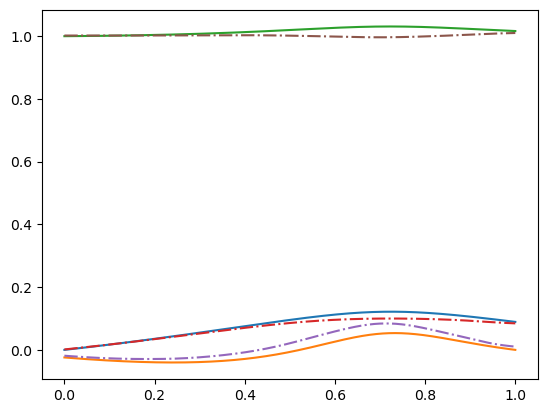

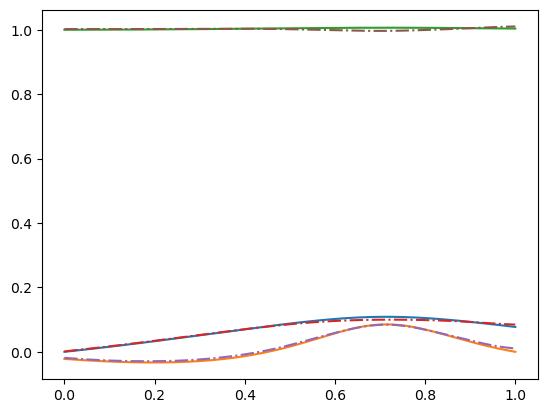

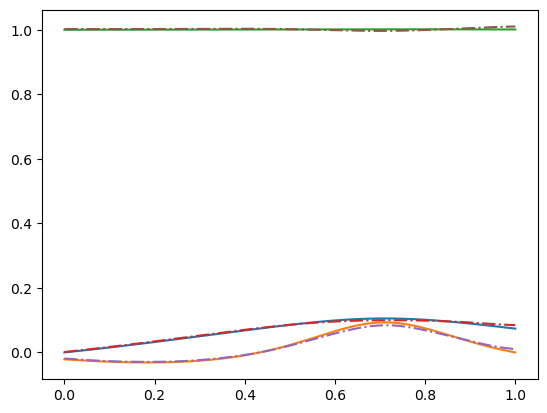

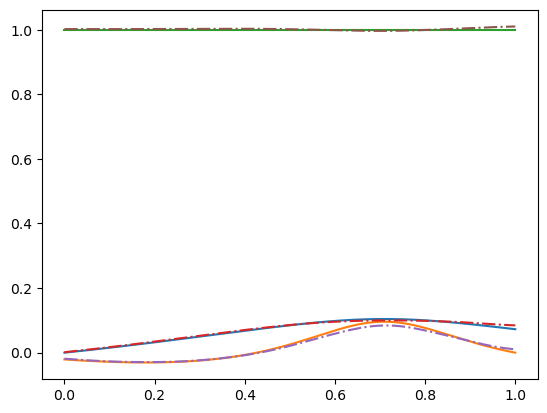

In [69]:
ff_test = [0.08, 0.02, 0.005, 0.000]
test_loss = {}
ff_est = {}
for f_test in ff_test:

    inputs, targets, meanflow =  dt.DataPreprocessing(data, ff=f_test)
    test_loader = dt.DataTransformer(inputs, targets, meanflow, TrainingSet=False)
    with torch.no_grad():
        val_loss = 0.0
        for k, (A, B, C) in enumerate(test_loader):
            u_pred = PINN_model.dnn(A)
            val_loss += torch.linalg.norm((B-u_pred),2)/torch.linalg.norm(B,2)
            #val_loss += PINN_model.Loss(A, B, C).item()

        val_loss /= len(val_loader) # Average Validation Loss
        test_loss[k] = val_loss

    plt.figure()
    plt.plot(inputs[:,1], targets)
    plt.plot(inputs[:,1], PINN_model.dnn(inputs).detach(), '-.')


In [70]:
PINN_model.f

Parameter containing:
tensor([0.1121], requires_grad=True)